In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# generate a phase diagram for a toy system using polyphase
import polyphase as phase
import numpy as np

M = [5,5,1]
chi = [1, 0.5, 0.5]
f = lambda x : phase.flory_huggins(x, M, chi)
engine = phase.PHASE(f,200,3)
engine.compute(use_parallel=False, verbose=True, lift_label=True)

3-dimensional grid generated at 0.18s
Energy computed at 1.47s
Aplpying 2x padding of 0.11 maximum energy
Energy is corrected at 1.94s
Simplices are computed and refined at 2.04s
Total of 9599 simplices in the convex hull
Using 1.01E-01 as a threshold for Laplacian of a simplex
Simplices are labelled at 2.76s
Labels are lifted at 6.45s
Total 0/9599 coplanar simplices
Computation took 6.64s


In [19]:
# to make use of the parallel computation pipeline
#engine.compute(use_parallel=True, verbose=True, lift_label=True)

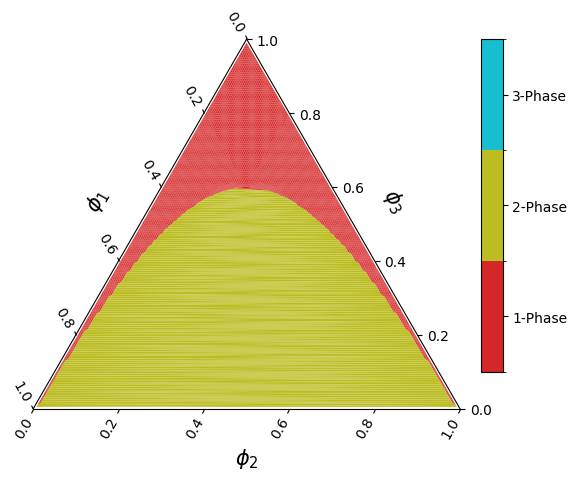

In [20]:
import matplotlib.pyplot as plt

engine.plot()
plt.show()

In [21]:
# We can also compute phase splits given a composition using the following
boundary_points = np.asarray([engine.is_boundary_point(x) for x in engine.grid.T])
no_boundary_grid = np.where(~boundary_points)[0]
point = engine.grid[:,np.random.choice(no_boundary_grid)]
print(point)
engine(point)

[0.44221106 0.27135679 0.28643217]


(array([4.92780333e-01, 4.98873100e-01, 1.52331908e-16]),
 array([[0.02512564, 0.69346734, 0.27638192],
        [0.02512564, 0.68844221, 0.28140704],
        [0.68844221, 0.02512564, 0.28140704]]),
 np.int64(2))

/Users/olgawodo/MINE/Students/SeanC/phaseDiagram/polyphase/polyphase/utils.py:54: RuntimeWarning: invalid value encountered in log
  T1 += (xi*np.log(xi))/M[i] + beta/xi


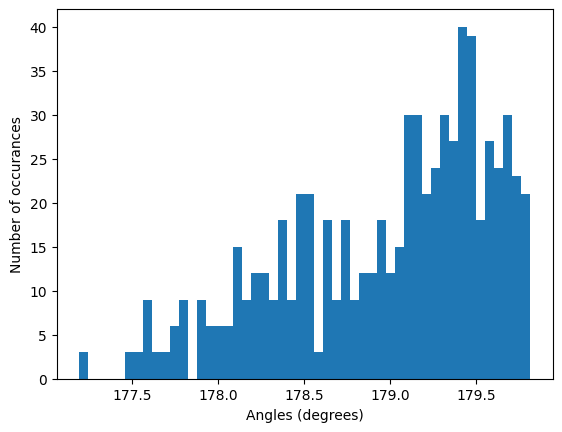

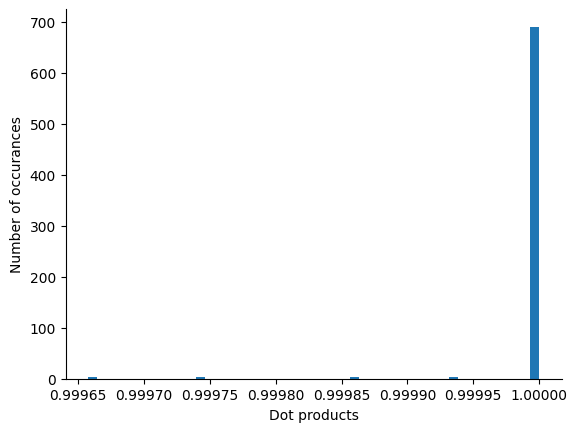

In [22]:
# performing tangent normal test
gradient = phase.CentralDifference(f)  
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==2)[0]
outlist = []
for simplex_id in phase_simplices_ids:
    test = phase.TestAngles(engine,phase=2,simplex_id=simplex_id)
    test_out = test.get_angles(gradient)
    for _, value in test_out['thetas'].items():
        outlist.append([value[2], value[3]])

outlist = np.asarray(outlist)        
assert len(outlist)==len(phase_simplices_ids)*3    
fig, ax = plt.subplots()
ax.hist(outlist[:,0],bins=50, density=False)
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Number of occurances')

fig, ax = plt.subplots()
ax.hist(outlist[:,1],bins=50, density=False)
ax.set_xlabel('Dot products')
ax.set_ylabel('Number of occurances')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [23]:
# Perform phase splitting test
PHASE_ID = 2
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==PHASE_ID)[0]
failed = []
criteria = engine.df.T['label']==PHASE_ID
lengths = []
for simplex_id in phase_simplices_ids:
    test = phase.TestPhaseSplits(engine,phase=PHASE_ID,simplex_id=simplex_id, threshold=0.05)
    if not test.check_centroid():
        failed.append(simplex_id)

print('{}/{} simplices failed the test'.format(len(failed), len(phase_simplices_ids)))

2/235 simplices failed the test
